# Lab 2 - Pattern recognition with memristive networks

In this lab, we will work through an end-to-end example using a random network of memristors. Essentially this network is a bunch of $N$ randomly connected resistive switches that act like little mini neurons. We apply a current to a single element, and read the current from $M$ readout elements. The network acts as a complex dynamical system that nonlinearly transforms the input signals into a higher dimensional feature space so that they might be more linearly separable. We then perform regression on the readouts. Ordinarily for classification tasks, you would use logistic regression, so that's what we'll do.

This example might closely follow a project that some of you might be working on, where you are running simulations, performing some machine learning, all the while collecting other data.

Our workflow is roughly as follows:
1. Create a random memristor network
2. Define the simulation input parameters
3. Define the input voltage
4. Apply the input voltage to the network and read the outputs
5. Do a downstream task with the outputs.

In [17]:
from reservoir import MemristorSim
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from seeds import set_all_seeds

set_all_seeds(0)

Connected network found


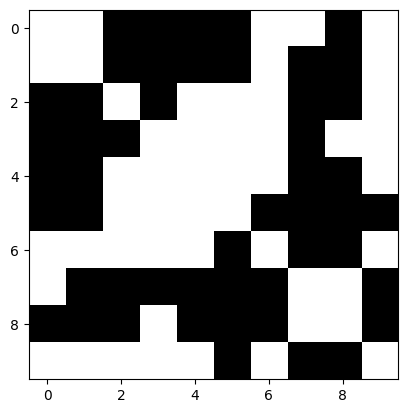

In [18]:
# Create random connectivity matrix with 10 nodes
def create_adjacency_matrix(shape=10):
    while True:
        try:
            W = np.random.randint(0,2, (shape,shape))
            W ^= W.T
            if nx.is_connected(nx.from_numpy_array(W)) == True:
                print("Connected network found")
                return W
        except:
            "Disconnected network, trying again..."

W = create_adjacency_matrix(10)
plt.imshow(W, 'Greys')
plt.show()

Next we define the simulation parameters. These may be fixed due to physical constraints, or they may be open to optimization. We also define an input stream. For now, we'll just do a test input, to see what the output looks like.

In [19]:
simParams = {
            'MU': 3.46e-5,
            'KAPPA': 0.038,
            'R_ON': 13e3,
            'R_OFF': 13e3 / 1e-2,
            'z_0': 0.05,
            'dist': 'normal',
            'var': 0,
            'NOISE': 0.0,
            'THETA': 10
        }

Vext = np.concatenate([np.ones((500,1))*1, np.zeros((500,1))])*0.1
Vext.shape

(1000, 1)

In [20]:
sim = MemristorSim(W, simParams)
output = sim.applyVoltage(Vext, outputs=5)
output[0].shape

(1000, 5)

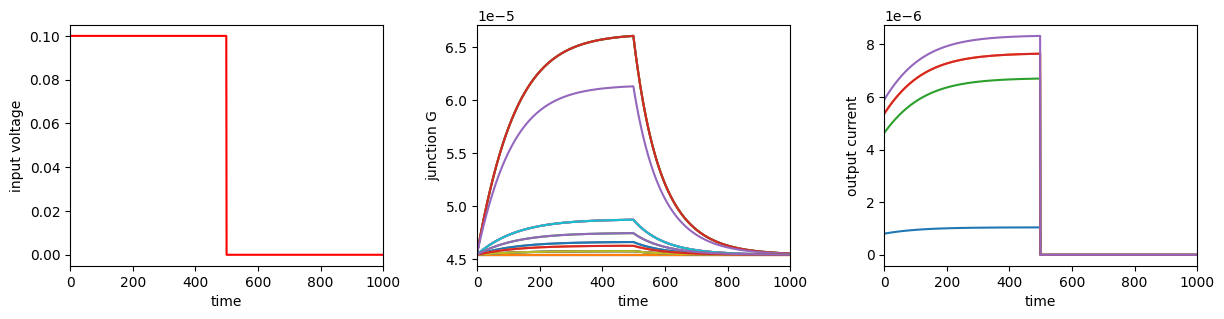

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), sharex=True)
fig.tight_layout()
ax1.plot(Vext, 'r')
ax2.plot(output[1][1:,:])
ax3.plot(output[0][1:,:])

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('time')
    ax.set_xlim(0, 1000)
ax1.set_ylabel('input voltage')
ax2.set_ylabel('junction G')
ax3.set_ylabel('output current')
fig.subplots_adjust(wspace=0.3)
plt.show()

### Get inputs
The inputs will be the toy MNIST digits example from earlier.

In [22]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

digits = load_digits()

In [23]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print(y_train.shape, y_val.shape, y_test.shape)

(1010,) (337,) (450,)


### Scale
Now we scale our input voltage. We need to create two scalers, one for the input voltage, and a second scaler for use on the outputs. The voltage range here might be open to optimization, so to make things clear, we'll call the range `(V_MIN, V_MAX)`. We will also decide how many nodes we want to collect output current form.

In [24]:
V_MIN = 0.01
V_MAX = 0.11
N_OUTPUTS = 3

voltage_scaler = MinMaxScaler(feature_range=(V_MIN, V_MAX))
regular_scaler = MinMaxScaler(feature_range=(0,1))

voltage_scaler.fit(X_train)
X_train_scaled = voltage_scaler.transform(X_train)
X_val_scaled = voltage_scaler.transform(X_val)

In [25]:
X_train_scaled = X_train_scaled.repeat(10, axis=1)
X_val_scaled = X_val_scaled.repeat(10, axis=1)
X_train_scaled.shape

(1010, 640)

In [26]:
training_outputs = np.zeros((*X_train_scaled.shape, N_OUTPUTS))
validation_outputs = np.zeros((*X_val_scaled.shape, N_OUTPUTS))

### Train and validate

In [11]:
for i in tqdm(range(X_train_scaled.shape[0])):
    Vext = X_train_scaled[i, :].reshape((-1,1))
    sim = MemristorSim(W, simParams)
    output, _ = sim.applyVoltage(Vext, outputs=N_OUTPUTS)
    training_outputs[i,...] = output

for i in tqdm(range(X_val_scaled.shape[0])):
    Vext = X_val_scaled[i, :].reshape((-1,1))
    sim = MemristorSim(W, simParams)
    output, _ = sim.applyVoltage(Vext, outputs=N_OUTPUTS)
    validation_outputs[i,...] = output

  0%|          | 0/1010 [00:00<?, ?it/s]

100%|██████████| 337/337 [00:26<00:00, 12.79it/s]


We now sample every 10th data point and do some reshaping:

In [12]:
training_outputs_sel = training_outputs[:, 9::10, :]
validation_outputs_sel = validation_outputs[:, 9::10, :]
flattened_training_outputs = training_outputs_sel.reshape((training_outputs_sel.shape[0], training_outputs_sel.shape[1]*training_outputs_sel.shape[2]))
flattened_validation_outputs = validation_outputs_sel.reshape((validation_outputs_sel.shape[0], validation_outputs_sel.shape[1]*validation_outputs_sel.shape[2]))

Now we are ready to apply logisitic regression and do some classification. But first, we just run a quick baseline test: how well does just basic logistic regression perform on the scaled digits?

### Baseline model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [28]:
# baseline = MultiOutputRegressor(LinearRegression())
baseline = LogisticRegression(solver='lbfgs', max_iter=4000)
baseline_scaler = MinMaxScaler()

baseline_scaler.fit(X_train)

baseline.fit(baseline_scaler.transform(X_train), y_train)
y_pred_baseline = baseline.predict(baseline_scaler.transform(X_val))

print(f"accuracy: {100*accuracy_score(y_val, y_pred_baseline):.2f}%")

accuracy: 96.14%


So that's actually a pretty good score! Can our first attempt using a random memristor network beat it?

In [15]:
# reg = MultiOutputRegressor(LinearRegression())
reg = LogisticRegression(solver='lbfgs', max_iter=1000)
regular_scaler = MinMaxScaler()
regular_scaler.fit(flattened_training_outputs)
scaled_training_outputs = regular_scaler.transform(flattened_training_outputs)

reg.fit(scaled_training_outputs, y_train)

y_pred = reg.predict(regular_scaler.transform(flattened_validation_outputs))

In [16]:
print(f"accuracy: {100*accuracy_score(y_val, y_pred):.2f}%")

accuracy: 96.44%


So only just. If we go back and fiddle with some of the parameters, can we do even better? What can we actually change? Let's assume that the internal simulation parameters are bound by the physics of our problem, so we can't change any of those. Instead, we might want to look at the follow parameters:
- $N$
- $V_{min}$ and $V_{max}$
- $N_{out}$

In order to compare the performance from logistic regression and the network, we have to be able to average over multiple seeds. It's time to move away from the notebook for now, and write some functions...